# Proyecto 1

Juan Camilo Sánchez – 201519337

Zharet Bautista Montes – 201812763

Leonel Andrés Polanía Arias - 201720141

## 1. Importación de librerias

In [2]:
import numpy as np
import pandas as pd
import re
import joblib

import contractions
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline

# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold 

from sklearn.metrics import classification_report, plot_confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/datalore/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2. Carga de datos

In [2]:
df = pd.read_csv('Reviews.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


## 3. Preparación de Datos

- Pasar a minúscula
- Expandir las contracciones 
- Eliminar stopwords
- Concatenar

In [4]:
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = ' '.join(word for word in re.split('\W', text) if word not in STOPWORDS)
    return text

In [5]:
df['Text'] = df['Text'].apply(clean_text)

In [28]:
df.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,bought several vitality canned dog food produc...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled jumbo salted peanuts ...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",confection around centuries light pillowy c...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,looking secret ingredient robitussin believe f...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy great price wide assortment yumm...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,got wild hair taffy ordered five pound bag ta...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,saltwater taffy great flavors soft chewy can...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",taffy good soft chewy flavors amazing wo...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,right I mostly sprouting cats eat grass love ...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,healthy dog food good digestion also good sm...



Se utiliza la columna Text como varialbe predictora y el score como variable objetivo. 
Se separa entre entrenamiento y evaluación tomando 20% de los datos para evaluación.

In [6]:
X = df['Text']
y = df['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [7]:
X_train.shape

(454763,)

## 4. Construcción del Modelo - Linear Support Vector Machine

El modelo consiste en tres elementos:

- Contador de frecuencias
- Transformador de frecuencia inversas
- Support Vector Machine de Kernel lineal 

In [13]:
vect = CountVectorizer()
tfidf = TfidfTransformer()
svm = LinearSVC()
pipeline = Pipeline([('vect', vect),
               ('tfidf', tfidf),
               ('svm', svm),
              ],
            verbose = True)

Debido a la gran cantidad de datos se utiliza validación cruzada K-fold de dos particiones, para hallar la constante de regularización adecuada, es decir, la que de mejor f1-score.

In [16]:
splits = KFold(n_splits=2, shuffle=True, random_state = 0)
param_grid = {'svm__C': np.logspace(-3, 3, num = 7)}
best_model = GridSearchCV(pipeline, param_grid, cv=splits, scoring = 'f1_weighted', n_jobs=-1)
best_model.fit(X_train, y_train)

[Pipeline] .............. (step 1 of 3) Processing vect, total=  25.4s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   5.0s
[Pipeline] ............... (step 3 of 3) Processing svm, total=11.6min


GridSearchCV(cv=KFold(n_splits=2, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('svm', LinearSVC())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'svm__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='f1_weighted')

El mejor modelo tiene como constante de regularización C = 10.

In [17]:
best_model.best_params_

{'svm__C': 10.0}

In [26]:
joblib.dump(best_model, 'lsvc.joblib')

['lsvc.joblib']

In [18]:
y_pred = best_model.predict(X_train)
print(classification_report(y_train, y_pred, target_names=['1','2','3','4', '5']))

              precision    recall  f1-score   support

           1       0.85      0.86      0.85     41942
           2       0.84      0.62      0.71     23914
           3       0.79      0.61      0.69     34155
           4       0.78      0.51      0.62     64532
           5       0.87      0.97      0.92    290220

    accuracy                           0.85    454763
   macro avg       0.82      0.71      0.76    454763
weighted avg       0.84      0.85      0.84    454763



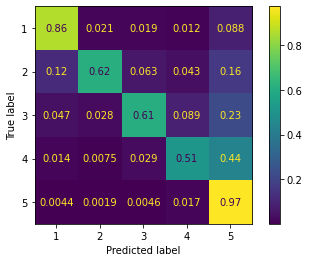

In [21]:
plot_confusion_matrix(best_model, X_train, y_train, normalize='true')

In [12]:
best_model = joblib.load('lsvc.joblib')
best_model.cv_results_

{'mean_fit_time': array([  18.03067923,   17.9803195 ,   18.13661706,   32.11136293,
         406.08052754, 1212.26751173, 1443.03402495]),
 'std_fit_time': array([ 0.16869831,  0.04827976,  0.10443747,  0.13675904,  3.89250994,
         8.56689322, 28.00241494]),
 'mean_score_time': array([10.48838139, 10.61468172, 10.73501039, 10.79816484, 10.75639153,
        36.04274201, 10.74499357]),
 'std_score_time': array([ 0.14424086,  0.10632682,  0.06002283,  0.10210919,  0.08946133,
        24.66689301,  0.1718632 ]),
 'param_svm__C': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'svm__C': 0.001},
  {'svm__C': 0.01},
  {'svm__C': 0.1},
  {'svm__C': 1.0},
  {'svm__C': 10.0},
  {'svm__C': 100.0},
  {'svm__C': 1000.0}],
 'split0_test_score': array([0.50160112, 0.61680078, 0.684481  , 0.72041721, 0.72500141,
        0.7136647 , 0.69922938]),
 

A continuación se muestra en más detalle el efecto de C en el desempeño del modelo.

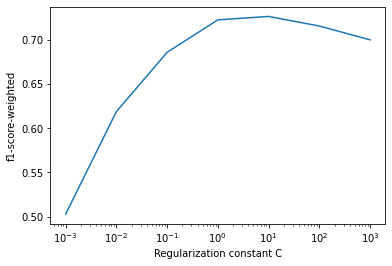

In [13]:
plt.plot(np.logspace(-3, 3, num = 7), best_model.cv_results_['mean_test_score'])
plt.xlabel('Regularization constant C')
plt.ylabel('f1-score-weighted')
plt.xscale('log')
plt.show()

## 5. Evaluación del modelo

Ahora se evalua definitivamente el desempeño del modelo en el conjunto de evaluación:

In [22]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['1','2','3','4', '5']))

              precision    recall  f1-score   support

           1       0.69      0.70      0.70     10326
           2       0.54      0.36      0.44      5855
           3       0.53      0.38      0.44      8485
           4       0.55      0.36      0.43     16123
           5       0.82      0.93      0.88     72902

    accuracy                           0.76    113691
   macro avg       0.63      0.55      0.58    113691
weighted avg       0.74      0.76      0.74    113691



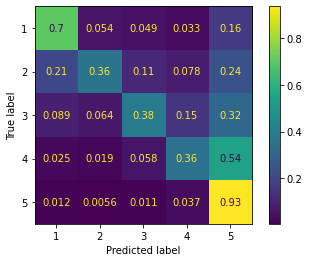

In [23]:
plot_confusion_matrix(best_model, X_test, y_test, normalize='true')